In [1]:
from core import download_IC
from core import download_ATNF

In [2]:
from core import readfiles
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
import scipy.stats as sct
from numba import jit, njit, prange, set_num_threads, vectorize
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *

read icdata
read uptdata
read eadata
read mspdata


In [3]:
set_num_threads(int(mul.cpu_count()*0.9))

In [4]:
# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
enus = np.logspace(11.001, 18.999, 2000)

In [5]:
np.diff(all_enu).shape

(40,)

In [6]:
gamma_arr = [-1, -2.2, -2.5, -3]
phio = np.logspace(-38, -26, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

#Uncomment to compute the background PDF for all neutrinos as per eqn 9 of 2205.15963

#and store them at /data/all_Bi.dat

#then recomment it


all_Bi = signals(4).compute_background()
all_Bi.tofile(os.getcwd() + '/data/all_Bi.dat', sep=',')

In [7]:
#
all_Bi = np.loadtxt(os.getcwd() + '/data/all_Bi.dat', delimiter=',')

In [8]:
weight_obj =  [weights.weights(gamma).all_weights for gamma in gamma_arr]
sum_weights = [weights.weights(gamma).sum_weights for gamma in gamma_arr]

In [11]:
#Calculating weight/sum(weights) to avoid wrong ns = 0 entries 
normalized_wt = []
for gamma in range(4):
    temp = []
    for season in range(len(weight_obj[gamma])):
        temp.append(weight_obj[gamma][ea_season(season)]/sum_weights[gamma][ea_season(season)])
    normalized_wt.append(temp)

In [12]:
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963
all_Si = np.asfarray([signals(gamma_arr[i]).compute_signal() for i in tqdm(prange(4))])

100%|██████████| 4/4 [01:25<00:00, 21.46s/it]


In [13]:
#generates ns^ for a single pulsar a single season and a single energy

# @njit()
@vectorize(['float64(float64, float64, float64, float64, int64)'], target='parallel')
def ns_singleseason_sing_psr_HAT(dec,enu, gamma, phi0 = 1, season=0):
    '''
    This function returns the number of signal events for a single pulsar as in EQN3 of 2205.15963
    -------------------

    Parameters
    ----------
    dec : float
        The declination of the pulsar in radians
    
    enu : float
        The neutrino energy in eV

    gamma : float
        The spectral index of the neutrino flux

    phi0 : float (optional)
        The normalization constant of the neutrino flux

    season : int (optional)
        The IceCube season number
    
    Returns
    -------
    float
        The number of signal events for the given parameters
    '''


    tt_upt = t_upt[season]
    if enu <= 1e11 or enu >= 1e19:
        return 0.0
    else:
        k=0
        l=0
        for i in range(0, len(e_nu_wall)):
            if e_nu_wall[i] <= enu and e_nu_wall[i+1] > enu:
                k=i
                break

        for j in range(0, len(dec_nu)):
            if dec_nu[j] <= dec and dec_nu[j+1] > dec:
                l=j
                break

            
        temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
        return tt_upt * temp_ea * phi0 * ((enu/(10**14))**gamma)     #in s cm2 eV


In [14]:
t = np.logspace(11.001, 18.999, int(1e4))

def ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma, e_nus=enus, phi0=1):
    ns_hat = 0
    ns_hat_wt = 0
    for season in tqdm(prange(10)):
        for psr in prange(p):
            wt = normalized_wt[gamma_arr.index(gamma)][ea_season(season)][psr]
            nsop = ns_singleseason_sing_psr_HAT(msdec[psr], e_nus, gamma, phi0, season)
            ns_hat_wt += wt * np.trapz(nsop, x=e_nus)
            ns_hat += np.trapz(nsop, x=e_nus)
    return np.array([ns_hat, ns_hat_wt], dtype=np.float64)


pool = mul.Pool(int(mul.cpu_count()*0.9))
op_async = pool.map_async(ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights, gamma_arr)
arr= op_async.get()
pool.close()
pool.join()

100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


In [15]:
all_TSS = []
for wt in range(2):
    tmp = []
    for gamma in range(4):
        @njit
        def TS_for_all_psrs2(nsa):  
            return Ts_arr2(nsa, all_Si[gamma], all_Bi, Ns)      #No units

        pool = mul.Pool(int(mul.cpu_count()*0.9), maxtasksperchild=200)
        op_arr = pool.map_async(TS_for_all_psrs2, arr[gamma][wt]*phio) #No units
        temp = op_arr.get()
        pool = []
        op_arr = []
        tmp.append(temp)

    all_TSS.append(tmp)

### $N \approx 10^6$

In [16]:
np.shape(all_TSS)

(2, 4, 1000)

In [17]:
for w in range(2):
    for g in range(4):
        print(min(all_TSS[w][g]), max(all_TSS[w][g]))
    print('wt\n')

-6038807.601822323 -1.973796663133825e-06
-7602597.21434315 -3.1812273270715196e-08
-5952172.174411158 -5.2345615550700175e-08
-8628926.314222315 -2.5940178378912916e-07
wt

-16998.301290361127 -5.049978213863906e-10
-45.41772174446817 1.3143353072560776e-10
-144.1622026391086 9.929101984999526e-11
-3260.3639501734056 3.311417806019252e-11
wt



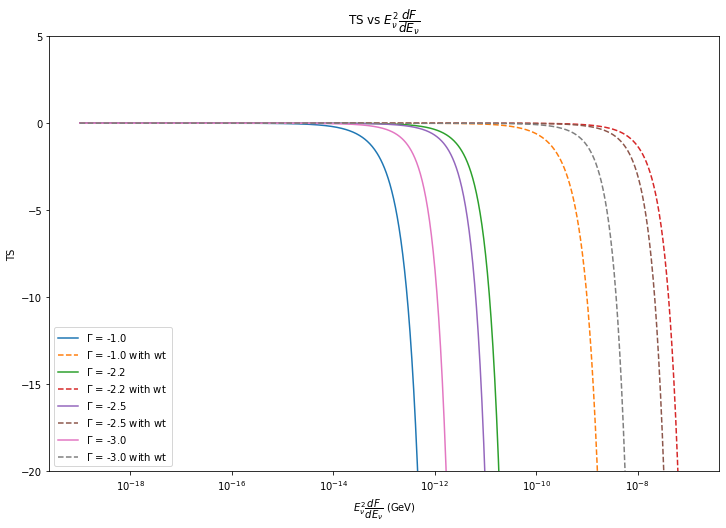

In [18]:
#Plotting

all_TSS = np.asarray(all_TSS)
gamma_arr = np.asarray(gamma_arr)
e2dfde = []

for gamma in prange(4):
    temp = []
    for phi in range(len(phio)):
        temp.append( 1e28 * dfde(1e14, gamma_arr[gamma], phio[phi]))        #in eV
    e2dfde.append(temp)

e2dfde = np.asarray(e2dfde)
mark = ['^', 'o', 's', 'd']
plt.figure(figsize=(12,8))
for gamma in [0, 1, 2, 3]:#range(4):
    plt.plot(e2dfde[gamma]/1e9, all_TSS[0][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))    #in GeV
    plt.plot(e2dfde[gamma]/1e9, all_TSS[1][gamma], ls='--',label='$\Gamma$ = ' + str(gamma_arr[gamma]) + ' with wt')    #in GeV

plt.legend()
plt.xscale('log')
plt.xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)')
plt.ylabel('TS')
plt.title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
# plt.xlim(1e-30, 1e-22)
plt.ylim(-20, 5)
plt.show()